# Bezier Simulations
This notebook follows the attempt of obtaining the shape of the transiting object from the lightcurve. We used simulations 
to generate arbitrary shapes, and their lightcurves. Now we use Neural Networks to train a system to recognize shape from
the input lightcurve.

PS: idk if it will work, because the bezier shapes are pretty similar to each other.

EDIT: It actually does pretty good, I'm surprised...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import sys
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold

sys.path.append('C:\\Users\\Hp\\Documents\FYProj\\alienworlds\\Data_Processing')

import GetLightcurves as gc

### Data Import
Here we import the training sample... creation of the training sample is in file 'bezierML_TS.py' located in the 'Data Processing directory.

In [2]:
XTrain, YTrain,Ptrain = gc.read_tfr_record('bezier_train',['lc','shape', 'pixel'],['ar','ar','ar'],[tf.float32, tf.float32, tf.int8])
XTest, YTest, Ptest = gc.read_tfr_record('bezier_test',['lc','shape', 'pixel'],['ar','ar','ar'],[tf.float32, tf.float32, tf.int8])

XTrain = np.array(XTrain)
YTrain = np.array(YTrain)
Ptrain = np.array(Ptrain)
XTest = np.array(XTest)
YTest = np.array(YTest)
Ptest = np.array(Ptest)
print('Train and Test data shapes:',XTrain.shape, Ptrain.shape, XTest.shape, Ptest.shape)

Train and Test data shapes: (4800, 500) (4800, 50, 50) (1200, 500) (1200, 50, 50)


In [30]:
# Noise addition 
np.random.seed(100000)
stds = np.array([0.01,0.005,0.001,0.0005])
XTrain_N = []
for el in XTrain:
    i = np.random.randint(0,4,1)
    noisearr = np.random.normal(1, stds[i], len(el))
    XTrain_N.append(np.multiply(el, noisearr))

XTrain_N = np.array(XTrain_N)

XTest_N = []
for el in XTest:
    i = np.random.randint(0,4,1)
    noisearr = np.random.normal(1, stds[i], len(el))
    XTest_N.append(np.multiply(el, noisearr))

XTest_N = np.array(XTest_N)

Plotting some instances from the training and test sample

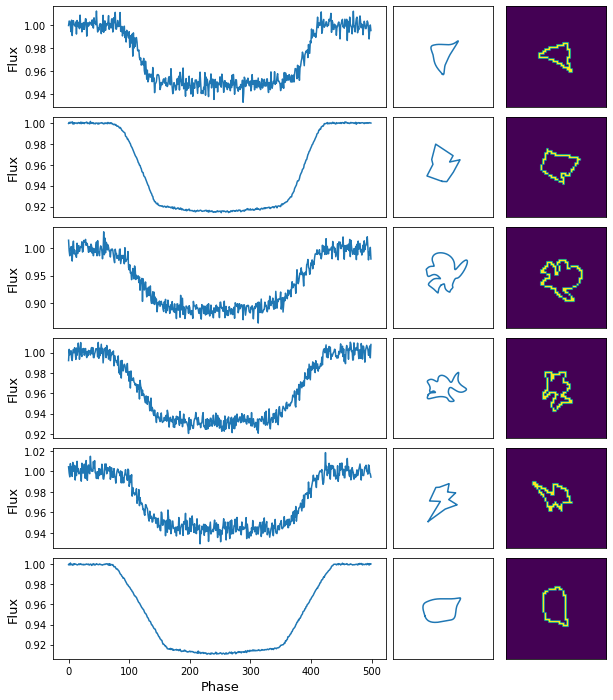

In [31]:
num = 6

fig,ax=plt.subplots(num,3, figsize=(10,12), gridspec_kw={ 'width_ratios': [3,1,1],
        'wspace': 0.01,'hspace': 0.1})
i=0

for i in range(num):
    ax[i][1].set_aspect('equal', adjustable='box')
    ax[i][0].plot(XTrain_N[i])
    ax[i][1].plot(YTrain[i,0], YTrain[i,1])
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    ax[i][1].set_xlim(-1,1)
    ax[i][1].set_ylim(-1,1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].imshow(Ptrain[i])
    ax[i][0].set_ylabel('Flux', size=13)

ax[num-1][0].set_xlabel('Phase', size=13)
# plt.suptitle('Simulation', size=15)

plt.show()

[21 22 23 24]
[22 23 24]
[23 24 26 27]
True 24 26
[16 17 18 19 20 23 24 26 27 28]
True 20 23
[16 17 18 19 20 23 24 26 27 28]
True 20 23
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 33 34]
True 31 33
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
[16 17 18 19 24 25 26 27 28 29 30 31 32 33]
True 19 24
[16 17 20 21 22 24 25 26 27 28 29 30 31 32 33]
True 17 20
[19 20 21 22 24 25 26 27 28 29 30 31 32]
True 22 24
[17 18 19 20 21 22 24 25 26 27 28 29 30]
True 22 24
[25 26]


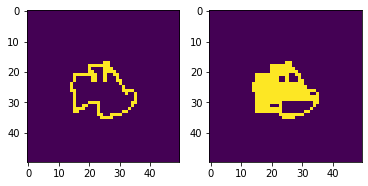

In [4]:
# tried to fill up the gaps in the shape but failed miserably
fig,ax=plt.subplots(1,2)
testshape = Ptrain[5].copy()

ax[0].imshow(Ptrain[5])
for x in range(0,len(testshape)):
    gap = False
    arr = np.where(testshape[x]==1)[0]
    if(len(arr)==0): continue
    mn = min(arr)
    mx = max(arr)
    left = np.setdiff1d(np.arange(mn,mx), arr)
    if(len(left)==0): continue
    print(left)
    for i in range(0,len(left)-1):
        if(gap==True): continue
        if(left[i]==left[i+1]-1 and not gap): testshape[x][left[i]]=1
        if(left[i]!=left[i+1]-1 and not gap): 
            testshape[x][left[i]]=1
            gap = not gap
            print(gap, left[i], left[i+1])
        elif(left[i]!=left[i+1]-1 and gap): 
            gap = not gap
    
    if(not gap): testshape[x][left[-1]]=1

ax[1].imshow(testshape)


### Network Architecture
The trial idea is to try a simple CNN... will have to build on it as the work progresses

In [32]:
def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def border_accuracy(y_true, y_pred):
    y_pred=tf.cast(y_pred,tf.float32)
    y_true=tf.cast(y_true,tf.float32)
    sm = tf.reduce_sum(y_true ,(1,2))
    marr = tf.math.multiply(y_true, y_pred)
    out =  tf.reduce_sum(marr,(1,2))/sm 
    # meanout = 1 - out
    meanout = tf.math.abs(tf.reduce_mean(meanout))
    return(meanout)

def sq_mse(y_true, y_pred):
    y_pred=tf.cast(y_pred,tf.float32)
    y_true=tf.cast(y_true,tf.float32)
    
    ones_w = tf.reduce_sum(y_true) / tf.cast(tf.reduce_prod(tf.shape(y_true)), tf.float32)
    w = (1-tf.square(ones_w))* y_true +tf.square(ones_w) * (1-y_true)
    w=tf.cast(w,tf.float32)

    val = tf.math.pow(y_pred - y_true, 2)
    op = tf.math.reduce_mean(tf.math.multiply(w, val))
    return(op)

val = sq_mse(Ptest, Ptest)
print(val)

tf.Tensor(0.0, shape=(), dtype=float32)


In [34]:
def bez():
     START = 500
     END = 50
     conv_ip = keras.layers.Input(shape=(START,),name='Input')
     x=keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
     x=keras.layers.BatchNormalization()(x)
     x=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='relu',name='conv16_5', padding='same')(x) 
     x=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
     x=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400
     x=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
     x=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
     x=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200
     x=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
     x=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
     x=keras.layers.MaxPool1D(3,strides=1,data_format='channels_last',name='maxpool_3', padding='same')(x) #100
     x=keras.layers.Flatten(name='flat_1')(x)

     x3=keras.layers.Dense(256,name='dense_layer_1',activation='relu')(x)
     x3=keras.layers.Dense(256,name='dense_layer_2',activation='relu')(x3)

     x3=keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x3)
     x3 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x3)

     x3=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x3)
     x3=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x3)
     x3=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x3)
     x3=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x3)
     conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x3)

     convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')
     convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
     return(convNN)

In [35]:
bezNN = bez()
bezNN.summary()


Model: "Convolutional_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 500)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 500, 1)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 1)            4         
_________________________________________________________________
conv16_5 (Conv1D)            (None, 500, 16)           64        
_________________________________________________________________
second_conv16_5 (Conv1D)     (None, 500, 16)           784       
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 250, 16)           0         
_________________________________________________________________
first_conv32_5 (Conv1D)      (None, 250, 32)      

In [36]:

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=bezNN.fit(XTrain_N,np.array(Ptrain,dtype='float32'), batch_size=128, epochs=120, verbose=1, validation_split=0.2)

Epoch 1/120
30/30 [==============================] - 26s 831ms/step - loss: 0.0320 - val_loss: 0.0314
Epoch 2/120
30/30 [==============================] - 20s 676ms/step - loss: 0.0290 - val_loss: 0.0274
Epoch 3/120
30/30 [==============================] - 20s 681ms/step - loss: 0.0269 - val_loss: 0.0271
Epoch 4/120
30/30 [==============================] - 21s 706ms/step - loss: 0.0267 - val_loss: 0.0273
Epoch 5/120
30/30 [==============================] - 20s 668ms/step - loss: 0.0265 - val_loss: 0.0278
Epoch 6/120
30/30 [==============================] - 21s 690ms/step - loss: 0.0263 - val_loss: 0.0285
Epoch 7/120
30/30 [==============================] - 20s 666ms/step - loss: 0.0263 - val_loss: 0.0289
Epoch 8/120
30/30 [==============================] - 20s 656ms/step - loss: 0.0262 - val_loss: 0.0294
Epoch 9/120
30/30 [==============================] - 22s 723ms/step - loss: 0.0262 - val_loss: 0.0293
Epoch 10/120
30/30 [==============================] - 21s 688ms/step - loss: 0.026

### Result Analysis
Here we demonstrate the results of the performed analysis

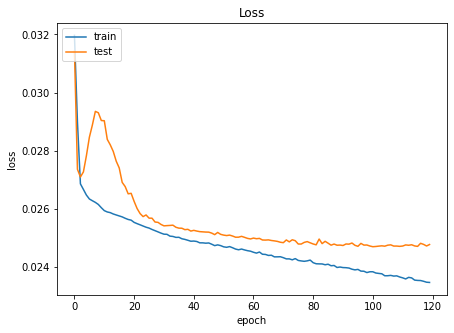

In [37]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.set_title('Loss')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
# plt.savefig('Mloss_SandN_tot_actual_un.png')

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('macc_SandN_actual_un.png')
# plt.show()
plt.show()

In [38]:
YPred = bezNN.predict(XTest_N)
YPredTr = bezNN.predict(XTrain_N)

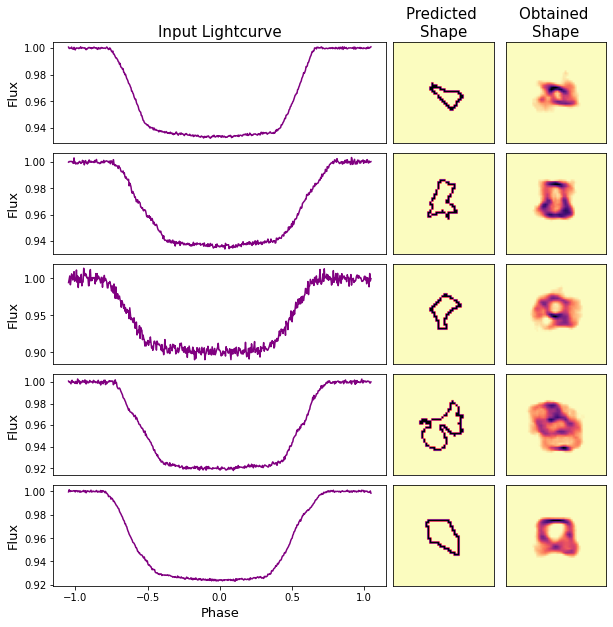

In [39]:
#pixelated plotting
num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [3,1,1],
        'wspace': 0.01,'hspace': 0.1})

ax[0][1].set_title('Predicted \nShape',size=15)
ax[0][0].set_title('Input Lightcurve',size=15)
ax[0][2].set_title('Obtained \nShape',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.047,1.047,len(XTrain[0]))

for i in range(num):
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    ax[i][1].imshow(Ptest[i+10],cmap='magma_r')
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].plot(ph, XTrain_N[i+10], color='purple')
    ax[i][2].imshow(YPred[i+10],cmap='magma_r')

plt.savefig('noiseruns_2.jpg')



In [11]:
YPredtemp = [(el>0.2) for el in YPred]

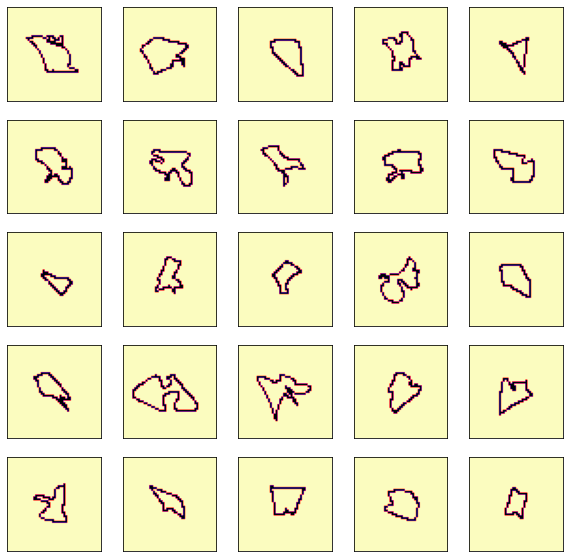

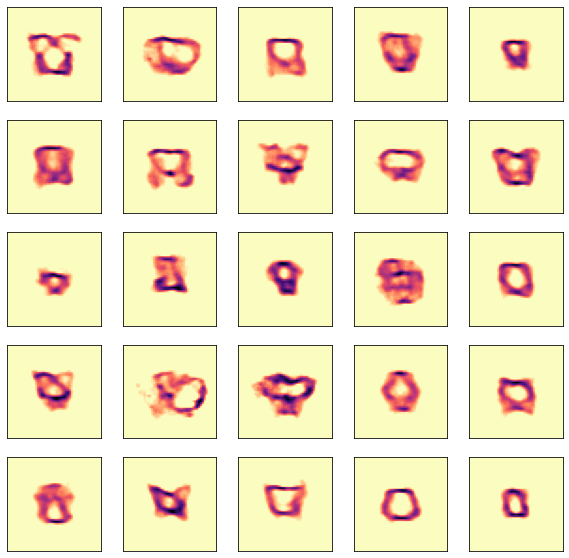

In [17]:
# another kind of plotting... for me.
num = 5
fig1, ax1 = plt.subplots(5,5, figsize=(10,10))
for i,ax in zip(np.arange(0,num**2), ax1.ravel()):
    ax.imshow(Ptest[i], cmap='magma_r')
    ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

fig2, ax2 = plt.subplots(5,5, figsize=(10,10))
for i,ax in zip(np.arange(0,num**2), ax2.ravel()):
    ax.imshow(YPred[i], cmap='magma_r')
    ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

plt.show()


We try and define a metric to evaluate the test sample.
We will use ssim and a self defined metric

In [18]:
def border_sim(y_true, y_pred):
    sm = y_true.reshape(-1).sum()
    marr = np.multiply(y_true + 0.005, y_pred)
    out = marr.reshape(-1).sum()/sm 
    return(out)

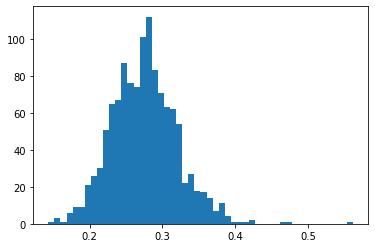

In [40]:
arr = [border_sim(tst, prd) for tst, prd in zip(Ptest, YPred)]
plt.hist(arr, bins=50)
plt.show()

### Bezier Curve Plot
This one is for sir's presentation

(4800, 2, 420)


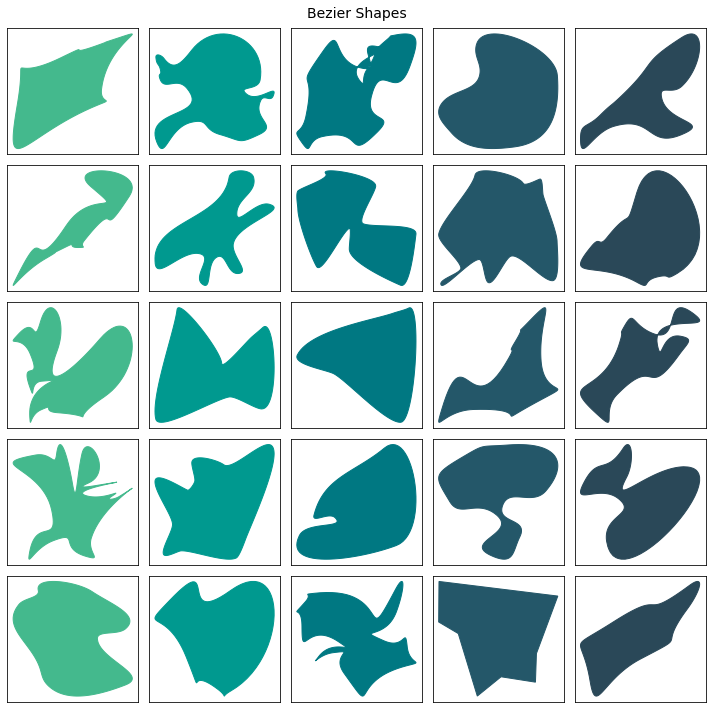

In [7]:
fig, axs = plt.subplots(5,5, figsize=(10,10))
ca2=["#44b98d","#00998f","#007882","#245769","#2a4858"]
plt.suptitle('Bezier Shapes', size=14)
print(YTrain.shape)

for i, ax in zip(np.arange(0,25), axs.ravel()):
    ax.fill(YTrain[i+90,0], YTrain[i+90,1], color=ca2[i%5])
    ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

plt.tight_layout()
# plt.savefig('bezshapes3.jpg')

plt.show()

### Orbit Normalization
Real data has a myriad parameters built into it. Orbital distance, size, and limb darkening parameters. We need to figure out
a way to fix all this... ideally normalize the transit such that we can eliminate the parameters from the story all together.

(size may be difficult, and limb darkening is pretty much impossible, so idk what we're gonna do about that...)

In [41]:
from transit import occultnonlin, occultquad
from scipy.optimize import curve_fit

def new_plar_ma(ph,p,u1,u2,rorb,imp):
    znp = np.sqrt(np.abs(rorb*np.sin(ph*np.pi))**2+imp**2)
    a= occultquad(znp,p,[u1,u2])  
    return(a)

# popt1, pcov1 = curve_fit(new_plar_ma, np.array(df['phase']), np.array(df['flux']), 
# bounds=([0,master_u1-0.01,master_u2-0.01,1,0], [1,master_u1+0.01,master_u2+0.01,40,1])) 

In [42]:
df = pd.read_csv('rorb_scaling.csv')

popt02, _ = curve_fit(new_plar_ma, np.array(df['frm_02'])/np.pi, np.array(df['lc_02']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,10,0.001]))
popt04, _ = curve_fit(new_plar_ma, np.array(df['frm_04'])/np.pi, np.array(df['lc_04']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,40,0.001]))
popt08, _ = curve_fit(new_plar_ma, np.array(df['frm_08'])/np.pi, np.array(df['lc_08']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,40,0.001]))
popt16, _ = curve_fit(new_plar_ma, np.array(df['frm_16'])/np.pi, np.array(df['lc_16']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,40,0.001]))
popt32, _ = curve_fit(new_plar_ma, np.array(df['frm_32'])/np.pi, np.array(df['lc_32']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,40,0.001]))
popt64, _ = curve_fit(new_plar_ma, np.array(df['frm_64'])/np.pi, np.array(df['lc_64']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,80,0.001]))

g02 = new_plar_ma(np.array(df['frm_02'])/np.pi, *popt02)
g04 = new_plar_ma(np.array(df['frm_04'])/np.pi, *popt04)
g08 = new_plar_ma(np.array(df['frm_08'])/np.pi, *popt08)
g16 = new_plar_ma(np.array(df['frm_16'])/np.pi, *popt16)
g32 = new_plar_ma(np.array(df['frm_32'])/np.pi, *popt32)
g64 = new_plar_ma(np.array(df['frm_64'])/np.pi, *popt64)

d02 = df['lc_02']-g02
d04 = df['lc_04']-g04
d08 = df['lc_08']-g08
d16 = df['lc_16']-g16
d32 = df['lc_32']-g32
d64 = df['lc_64']-g64



c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


2.0747238128013983 4.045488045833469


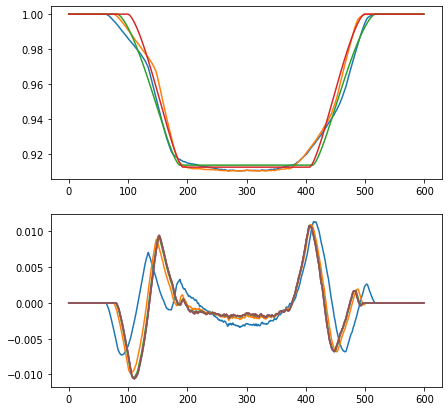

In [43]:

fig, ax = plt.subplots(2,1,figsize=(7,7))
ax[0].plot(df['lc_02'])
ax[0].plot(df['lc_04'])
# ax[0].plot(df['lc_08'])
# ax[0].plot(df['lc_16'])
# ax[0].plot(df['lc_32'])
# ax[0].plot(df['lc_64'])

ax[0].plot(g02)
ax[0].plot(g04)

ax[1].plot(df['lc_02']-g02)
ax[1].plot(d04)
ax[1].plot(d08)
ax[1].plot(d16)
ax[1].plot(d32)
ax[1].plot(d64)

print(popt02[3], popt04[3])

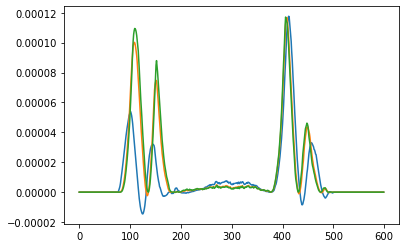

In [33]:
plt.plot(d02*d04)
plt.plot(d04*d16)
plt.plot(d08*d16)
# plt.plot(d16*d32)
# plt.plot(d32*d64)

# plt.plot((d08 +1)/(d16+1))
# plt.plot((d16 +1)/(d32+1))
# plt.plot((d04 +1)/(d08+1))

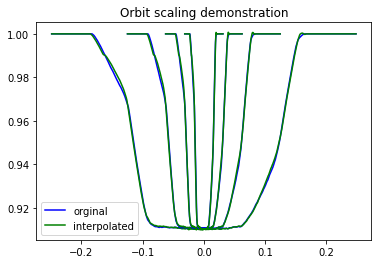

In [58]:
# g04, df['lc_04'], d04, g08
plt.title('Orbit scaling demonstration')

plt.plot(df['frm_08'],df['lc_08'], color='blue')
plt.plot(df['frm_08'],g08+d04, color='green')

plt.plot(df['frm_16'],df['lc_16'], color='blue')
plt.plot(df['frm_16'],g16+d04, color='green')

plt.plot(df['frm_32'],df['lc_32'], color='blue', label='orginal')
plt.plot(df['frm_32'],g32+d04, color='green', label='interpolated')

plt.plot(df['frm_64'],df['lc_64'], color='blue')
plt.plot(df['frm_64'],g16+d04, color='green')

plt.legend()
plt.savefig('analyseorbitscale.jpg')

### Size Normalization
Testing out a theory for normalising orbit sizes as well. Not perfect but the best so far

In [41]:
df = pd.read_csv('size_scaling.csv')

popt02, _ = curve_fit(new_plar_ma, np.array(df['frm_0.6'])/np.pi, np.array(df['lc_0.6']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,10,0.001]))
popt04, _ = curve_fit(new_plar_ma, np.array(df['frm_0.8'])/np.pi, np.array(df['lc_0.8']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,40,0.001]))
popt08, _ = curve_fit(new_plar_ma, np.array(df['frm_1.0'])/np.pi, np.array(df['lc_1.0']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,40,0.001]))
popt16, _ = curve_fit(new_plar_ma, np.array(df['frm_1.2'])/np.pi, np.array(df['lc_1.2']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,40,0.001]))
popt32, _ = curve_fit(new_plar_ma, np.array(df['frm_1.4'])/np.pi, np.array(df['lc_1.4']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,40,0.001]))
popt64, _ = curve_fit(new_plar_ma, np.array(df['frm_1.6'])/np.pi, np.array(df['lc_1.6']), 
    bounds=([0,0,0,1,0], [1,0.0001,0.0001,80,0.001]))

g02 = new_plar_ma(np.array(df['frm_0.6'])/np.pi, *popt02)
g04 = new_plar_ma(np.array(df['frm_0.8'])/np.pi, *popt04)
g08 = new_plar_ma(np.array(df['frm_1.0'])/np.pi, *popt08)
g16 = new_plar_ma(np.array(df['frm_1.2'])/np.pi, *popt16)
g32 = new_plar_ma(np.array(df['frm_1.4'])/np.pi, *popt32)
g64 = new_plar_ma(np.array(df['frm_1.6'])/np.pi, *popt64)

d02 = df['lc_0.6']-g02
d04 = df['lc_0.8']-g04
d08 = df['lc_1.0']-g08
d16 = df['lc_1.2']-g16
d32 = df['lc_1.4']-g32
d64 = df['lc_1.6']-g64

/home/ushasi/Documents/GitHub/alienworlds/Sims/transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


436 428
0.17587402493711057 0.23469479397871854 0.2937161944606269 0.3525576059008185 0.4108520340227843 0.4686356937556524


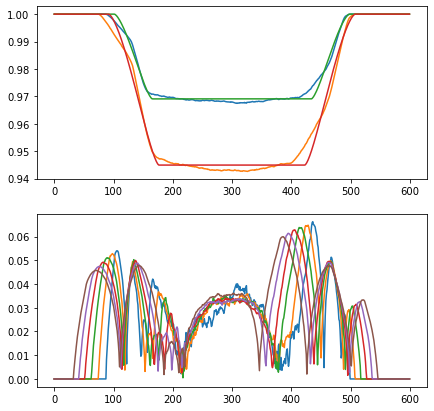

In [74]:
fig, ax = plt.subplots(2,1,figsize=(7,7))
ax[0].plot(df['lc_0.6'])
ax[0].plot(df['lc_0.8'])
# ax[0].plot(df['lc_08'])
# ax[0].plot(df['lc_16'])
# ax[0].plot(df['lc_32'])
# ax[0].plot(df['lc_64'])

ax[0].plot(g02)
ax[0].plot(g04)

ax[1].plot(np.power(np.abs(d02),0.5))
ax[1].plot(popt02[0]/popt04[0]*np.power(np.abs(d04),0.5))
ax[1].plot(popt02[0]/popt08[0]*np.power(np.abs(d08),0.5))
ax[1].plot(popt02[0]/popt16[0]*np.power(np.abs(d16),0.5))
ax[1].plot(popt02[0]/popt32[0]*np.power(np.abs(d32),0.5))
ax[1].plot(popt02[0]/popt64[0]*np.power(np.abs(d64),0.5))
# ax[1].plot(d08)
# ax[1].plot(d16)
# ax[1].plot(d32)
# ax[1].plot(d64)
print(np.argmax(d02), np.argmax(d04))

print(popt02[0],popt04[0],popt08[0],popt16[0],popt32[0], popt64[0])

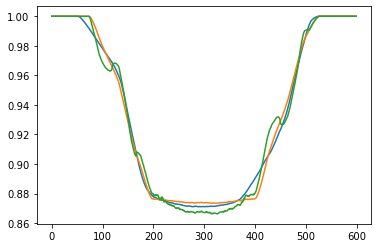

In [95]:
plt.plot(df['lc_1.2'])
plt.plot(g16+d04)
plt.plot(g16+popt04[0]/popt16[0]*np.power(np.abs(d04),0.7)*np.sign(d04))

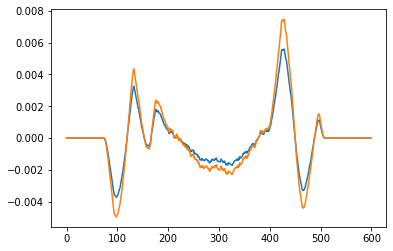

In [87]:
plt.plot(popt02[0]/popt04[0]*np.power(np.abs(d04),1)*np.sign(d04))
plt.plot(d04)